In [2]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.signal as signal

In [4]:
files = glob.glob("./run/*.csv")

li =[]
for name in files:
    dfx = pd.read_csv(name, sep=",", decimal=".", encoding='ansi')
    dfx = dfx.rename(columns=str.lower)
    dfx.columns = dfx.columns.str.replace(' ','_')
   # if dfx.iloc[1550,6] > 10:
    #    continue

    #print(name)
    #print (dfx.iloc[1550,6])
    for index, row in dfx.iterrows():
        if row["_lightbeam"].strip() == "B11":
            break
        else:
            dfx.drop(index=index,inplace=True)
            #print(index)

    counter =0
    for index, row in dfx.iterrows():
        if row["_lightbeam"].strip() == "2":
            counter=1
            continue
        if counter ==1:
            dfx.drop(index=index,inplace=True)

    # Tilt Angle berechnen -(math.degrees(math.atan(12/100)))
    dfx["tilt_value"] = -(np.degrees(np.arctan(dfx["_acc_y_m/s2"]/dfx["_acc_x_m/s2"])))      
    
    # First, design the Buterworth filter
    N  = 3    # Filter order
    Wn = 0.01 # Cutoff frequency Hz
    B, A = signal.butter(N, Wn, output='ba')
    dfx['acc_x_smooth'] = signal.filtfilt(B,A, dfx["_acc_x_m/s2"])
    dfx['acc_y_smooth'] = signal.filtfilt(B,A, dfx["_acc_y_m/s2"])
    dfx['acc_z_smooth'] = signal.filtfilt(B,A, dfx["_acc_z_m/s2"])
    # Tilt Angle berechnen -(math.degrees(math.atan(12/100)))
    dfx['tilt_smooth'] = -(np.degrees(np.arctan((dfx['acc_y_smooth'])/(dfx['acc_x_smooth']))))
    dfx['tilt_valsm'] = -(np.arctan((dfx['acc_y_smooth'])/(dfx['acc_x_smooth'])))

    ## Jetzt noch den optimalen Rollwinkel
    ## https://www.rathaus-winterberg.de/wohnen-leben/bau-planen/bebauungsplaene/
    ## https://geoservice.maps.arcgis.com/apps/View/index.html?appid=9565f4b2c14544b4a92b04a67958c79c


    dfx.loc[dfx["_roll_angle_°"] <=30, 'radius'] =0  
    dfx.loc[(dfx["_roll_angle_°"] < (-20) ) & (dfx["time_s"] >=8 ), 'radius'] =36.5 
    dfx.loc[(dfx["_roll_angle_°"] > 30 ) & (dfx["time_s"] >=8 ), 'radius'] = 20.5 

    # Definieren von Speed und Radius
    velocity = dfx["_speed_km/h"]/3.6
    radius = dfx['radius']

    dfx.loc[dfx["radius"] == 0, 'opt_rangle'] = 0

    dfx.loc[dfx["radius"] == 20.5, 'opt_rangle'] = (np.degrees(np.arctan((velocity ** 2)/(9.81*radius))))
    dfx.loc[dfx["radius"] == 36.5, 'opt_rangle'] = -(np.degrees(np.arctan((velocity ** 2)/(9.81*radius))))

    
    
    
    
    
    
    li.append(dfx)

frame = pd.concat(li, axis=0, ignore_index=True)
frame.describe()
pd.DataFrame(frame).to_csv("c:/dev/test_second_curve.csv",sep=";")

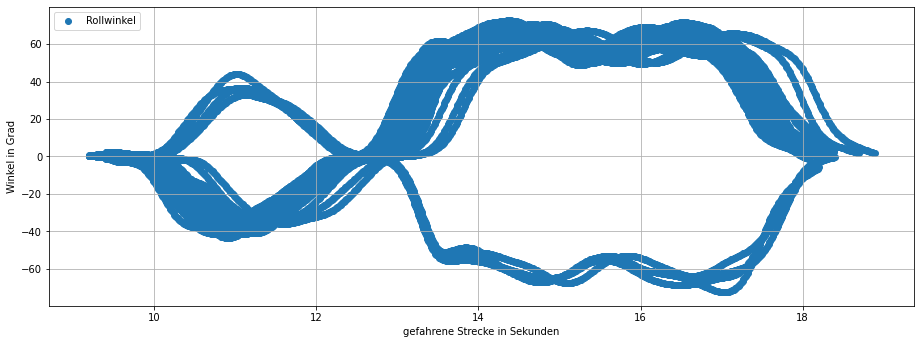

In [27]:
df = frame
plt.figure(figsize=(15.5, 5.5))
plt.scatter(df['time_s'],df['_roll_angle_°'], label='Rollwinkel')
#plt.scatter(df['time_s'],df['_speed_km/h'])
# plt.scatter(df['time_s'],df['opt_rangle'])
#plt.plot(df['time_s'],df['tilt_smooth'],'blue',df['time_s'],df['_roll_angle_°'],'red',df['time_s'],df['acc_z_smooth'],'orange' )
plt.xlabel('gefahrene Strecke in Sekunden')
plt.ylabel('Winkel in Grad')
plt.legend(loc='upper left')

plt.grid()
plt.show()

ValueError: Expect x to not have duplicates